# Hybrid Smart Forecaster


## 0) Imports


In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

# Deep learning (simple)
import tensorflow as tf
from tensorflow.keras import layers, models


## 1) Dataset

In [2]:
np.random.seed(42)

n = 600
t = np.arange(n)

season = 10*np.sin(2*np.pi*t/30)
trend = 0.02*t
noise = np.random.normal(0, 2.0, size=n)

y = 50 + trend + season + noise
df = pd.DataFrame({"ds": pd.date_range("2023-01-01", periods=n, freq="D"), "y": y})
df.head()


,ds,y
0,2023-01-01,50.993428
1,2023-01-02,51.822588
2,2023-01-03,55.402744
3,2023-01-04,58.983912
4,2023-01-05,57.043142


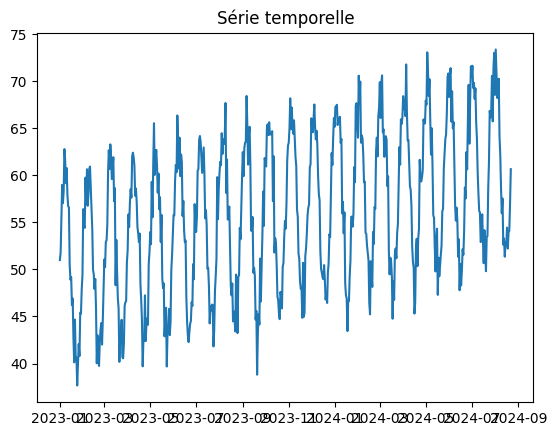

In [3]:
plt.figure()
plt.plot(df["ds"], df["y"])
plt.title("Série temporelle")
plt.show()


## 2) Train/Test split (time-based)


In [4]:
H = 30  # horizon de prévision (derniers H points)
train = df.iloc[:-H].copy()
test  = df.iloc[-H:].copy()

y_train = train["y"].values
y_test  = test["y"].values


## 3) Baseline ML tabulaire (lags -> Ridge)
On transforme la série en problème supervisé : prédire `y(t)` à partir de `y(t-1)`, `y(t-7)`, etc.


In [5]:
def make_lag_features(series, lags=[1,2,3,7,14,30]):
    X = {}
    for l in lags:
        X[f"lag_{l}"] = series.shift(l)
    return pd.DataFrame(X)

lags = [1,2,3,7,14,30]
feat = make_lag_features(df["y"], lags=lags)
data = pd.concat([df[["ds","y"]], feat], axis=1).dropna().reset_index(drop=True)

train2 = data.iloc[:-H].copy()
test2  = data.iloc[-H:].copy()

X_train = train2[[f"lag_{l}" for l in lags]].values
y_train2 = train2["y"].values
X_test  = test2[[f"lag_{l}" for l in lags]].values
y_test2 = test2["y"].values


In [6]:
baseline = Ridge(alpha=1.0)
baseline.fit(X_train, y_train2)
pred_baseline = baseline.predict(X_test)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"MAE": float(mae), "RMSE": float(rmse)}

m_baseline = metrics(y_test2, pred_baseline)
m_baseline


{'MAE': 1.8489777987698837, 'RMSE': 2.3755509026657653}

## 4) Deep Learning (LSTM simple)
On crée des fenêtres temporelles (`WINDOW`) et on prédit la prochaine valeur.


In [7]:
def make_windows(values, window=30):
    X, y = [], []
    for i in range(window, len(values)):
        X.append(values[i-window:i])
        y.append(values[i])
    X = np.array(X)[..., None]  # (samples, window, 1)
    y = np.array(y)
    return X, y

WINDOW = 30
values = df["y"].values.astype(np.float32)

Xw, yw = make_windows(values, window=WINDOW)

# split temporel (on garde la fin pour test horizon)
Xw_train, yw_train = Xw[:-H], yw[:-H]
Xw_test,  yw_test  = Xw[-H:],  yw[-H:]


In [8]:
model = models.Sequential([
    layers.Input(shape=(WINDOW,1)),
    layers.LSTM(32),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse")

history = model.fit(
    Xw_train, yw_train,
    epochs=15, batch_size=32,
    validation_split=0.1, verbose=0
)

pred_lstm = model.predict(Xw_test, verbose=0).reshape(-1)

m_lstm = metrics(yw_test, pred_lstm)
m_lstm


{'MAE': 49.023197174072266, 'RMSE': 49.56275368393462}

## 5) Sélection intelligente (ou ensemble)
- Si LSTM gagne clairement → **DEEP**
- Si baseline gagne clairement → **BASELINE**
- Sinon → **ENSEMBLE** pondéré (inverse des RMSE)


In [9]:
rmse_b = m_baseline["RMSE"]
rmse_d = m_lstm["RMSE"]

# règle simple
if rmse_d < 0.97 * rmse_b:
    strategy = "DEEP (LSTM)"
    final_pred = pred_lstm
    y_true = yw_test
elif rmse_b < 0.97 * rmse_d:
    strategy = "BASELINE (Ridge-lags)"
    final_pred = pred_baseline
    y_true = y_test2
else:
    strategy = "ENSEMBLE (pondéré)"
    # poids inverses des erreurs
    wb = 1/(rmse_b + 1e-9)
    wd = 1/(rmse_d + 1e-9)
    wsum = wb + wd
    final_pred = (wb/wsum)*pred_baseline + (wd/wsum)*pred_lstm
    y_true = y_test2  # même longueur H

final_metrics = metrics(y_true, final_pred)

strategy, final_metrics


('BASELINE (Ridge-lags)',
 {'MAE': 1.8489777987698837, 'RMSE': 2.3755509026657653})

## 6) Visualisation


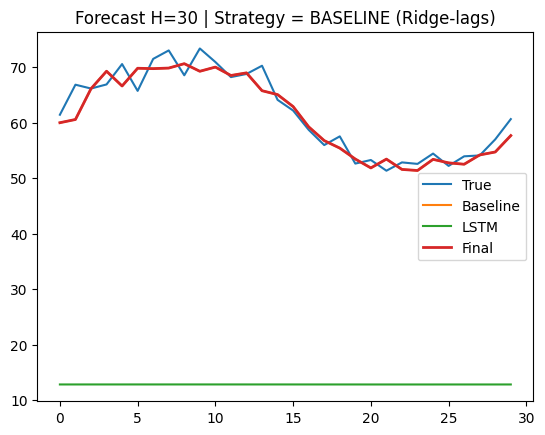

Interprétation rapide :
- Baseline RMSE = 2.376
- LSTM RMSE     = 49.563
=> Choix final   = BASELINE (Ridge-lags)


In [10]:
plt.figure()
plt.plot(range(H), y_true, label="True")
plt.plot(range(H), pred_baseline, label="Baseline")
plt.plot(range(H), pred_lstm, label="LSTM")
plt.plot(range(H), final_pred, label="Final", linewidth=2)
plt.title(f"Forecast H={H} | Strategy = {strategy}")
plt.legend()
plt.show()

print("Interprétation rapide :")
print(f"- Baseline RMSE = {rmse_b:.3f}")
print(f"- LSTM RMSE     = {rmse_d:.3f}")
print(f"=> Choix final   = {strategy}")
